In [1]:
print("Test notebook connection")

Test notebook connection


In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: jupyter in c:\users\kszon\appdata\local\programs\python\python312\lib\site-packages (from -r requirements.txt (line 1)) (1.1.1)




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pytorch_lightning as pl
from torchvision import transforms, datasets
import torch
import wandb
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
import gradio as gr
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.transforms.functional import to_pil_image
from captum.attr import IntegratedGradients, Saliency
from captum.attr import visualization as viz

In [4]:
TRAIN_MODELS_INSTEAD_OF_LOAD = False
DEPLOYMENT = True

In [5]:
!mkdir -p /app/checks
!touch /app/checks/gitkeep.txt

The syntax of the command is incorrect.
'touch' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
if DEPLOYMENT == False:
    wandb.login()

# **1. Data acquisition**

The images are mostly from Pinterest or other image sharing platforms.


They were downloaded and uploaded to this repository manually, from where this code can access it

# **2. Data analysis**

In [7]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [8]:
bagel_images = load_images_from_folder('images/train/bagel')
burger_images = load_images_from_folder('images/train/burger')
sandwich_images = load_images_from_folder('images/train/sandwich')

In [9]:
len(bagel_images), len(burger_images), len(sandwich_images)

(50, 50, 50)

### Class distribution
We have 50 images of three classes.

The classes are:
- Bagel
- Burger
- Sandwich

The class distribution is equal since we have 50 images in all classes, so there are no class imbalances.



In [10]:
dataset_path = 'images/train'

### Visualizing samples

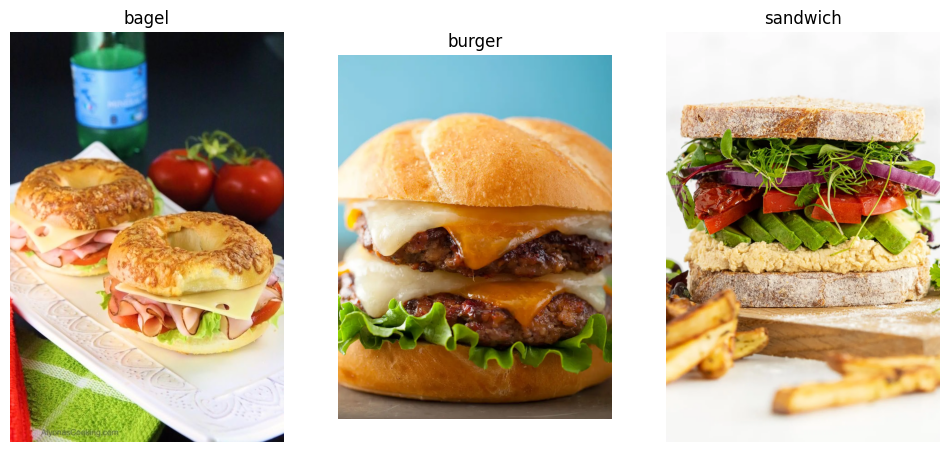

In [11]:
def analyze_dataset(dataset_path):
    class_samples = {}
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        
        if os.path.isdir(class_path):
            image_files = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]
            class_samples[class_name] = [os.path.join(class_path, img) for img in image_files[:5]]

    plt.figure(figsize=(12, 6))
    for idx, (class_name, samples) in enumerate(class_samples.items()):
        plt.subplot(1, len(class_samples), idx + 1)
        for img_path in samples:
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)
    plt.show()

analyze_dataset(dataset_path)

### Check image corruption

In [12]:
def check_image_corruption(dataset_path):
    corrupted_images = []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                if os.path.isfile(img_path):
                    try:
                        img = Image.open(img_path)
                        img.verify()
                    except Exception as e:
                        corrupted_images.append(img_path)
                        print(f"Corrupted image: {img_path}")

    if corrupted_images:
        print(f"Total corrupted images: {len(corrupted_images)}")
    else:
        print("No corrupted images found.")

check_image_corruption('images/train')
check_image_corruption('images/test')
check_image_corruption('images/val')

No corrupted images found.
No corrupted images found.
No corrupted images found.


### Statistical analysis

In [13]:
def calculate_image_statistics(dataset_path):
    widths, heights = [], []
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                if os.path.isfile(img_path):
                    img = Image.open(img_path)
                    widths.append(img.width)
                    heights.append(img.height)
    
    if widths and heights:
        print(f"Average width: {np.mean(widths)}, Average height: {np.mean(heights)}")
    else:
        print("No valid images found.")

calculate_image_statistics('images/train')
calculate_image_statistics('images/val')


Average width: 582.9066666666666, Average height: 703.9866666666667
Average width: 1152.0, Average height: 896.0


# **3. Data cleansing and preparation**

In [14]:
class BurgerBagelSandwichDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, resolution=224, num_workers=4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.resolution = resolution
        self.num_workers = num_workers

        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=self.resolution, scale=(0.2, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.85, 1.15), shear=15),
            transforms.RandomRotation(degrees=20),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.val_transform = transforms.Compose([
            transforms.Resize(size=self.resolution, antialias=True),
            transforms.CenterCrop(size=self.resolution),
            transforms.ToTensor(),
        ])

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = datasets.ImageFolder(
                root=f'{self.data_dir}/train',
                transform=self.train_transform
            )

            self.val_dataset = datasets.ImageFolder(
                root=f'{self.data_dir}/val',
                transform=self.val_transform
            )

        if stage == 'test' or stage is None:
            self.test_dataset = datasets.ImageFolder(
                root=f'{self.data_dir}/test',
                transform=self.val_transform
            )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            shuffle=True,
            drop_last=True,
            persistent_workers=True
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
        )

In [15]:
data_module = BurgerBagelSandwichDataModule(data_dir='images', batch_size=16, resolution=224, num_workers=1)
data_module.setup('fit')

class_names = data_module.train_dataset.classes
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

In [16]:
train_loader.dataset.classes, val_loader.dataset.classes

(['bagel', 'burger', 'sandwich'], ['bagel', 'burger', 'sandwich'])

# Phase 2

## Defining evaluation criteria 

- Accuracy: Ration of correctly predicted instances to the total instances
- Precision: Ratio of true positive predictions to the sum of true positives and false positives for each class
- Recall: Ratio of true positive predictions to the sum of true positives and false negatives for each class
- F1 Score: The harmonic mean of precision and recall. It provides a balance between the two metrics
- Confusion Matrix: A matrix that shows the number of correct and incorrect predictions broken down by class

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, dataloader, classes, logger=None):
    model = model.to(device)
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Optionally log metrics
    if logger:
        logger.experiment.log({
            "test_accuracy": accuracy,
            "test_precision": precision,
            "test_recall": recall,
            "test_f1_score": f1
        })
        
        if torch.cuda.is_available():
            logger.experiment.log({
                "gpu_memory_allocated (MB)": torch.cuda.memory_allocated(device) / (1024 ** 2)
            })
    
    # Per-class metrics
    print("\nClassification Report:")
    class_report = classification_report(y_true, y_pred, target_names=classes, zero_division=0)
    print(class_report)

    if logger:
        logger.experiment.log({"classification_report": class_report})
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")

    cm_image_path = "confusion_matrix.png"
    plt.savefig(cm_image_path)

    if logger:
        logger.experiment.log({"Confusion Matrix": wandb.Image(cm_image_path)})
        
    plt.show()
    
    # Return the computed metrics
    return metrics

## Error Analysis

In [18]:
def visualize_errors(model, dataloader, class_names, num_samples=5):
    """
    Visualizes incorrect predictions from the model.
    
    Args:
        model: Trained PyTorch model.
        dataloader: DataLoader for test/validation dataset.
        class_names: List of class names.
        num_samples: Number of incorrect samples to visualize.
    """
    model.eval()
    incorrect_samples = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            incorrect_idx = (preds != labels).nonzero(as_tuple=True)[0]
            
            for idx in incorrect_idx:
                incorrect_samples.append((inputs[idx], labels[idx].item(), preds[idx].item()))
                if len(incorrect_samples) >= num_samples:
                    break
            if len(incorrect_samples) >= num_samples:
                break
    
    # Visualize incorrect samples
    for img, true_label, pred_label in incorrect_samples:
        img = img.permute(1, 2, 0).cpu().numpy()
        plt.imshow(img)
        plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[pred_label]}")
        plt.axis('off')
        plt.show()

### Default hyperparameters

In [19]:
default_max_epochs = 100
default_learning_rate = 1e-3
default_weight_decay = 1e-5

### Define some helper functions

In [20]:
def preprocess_image(image_path, resolution=224):
    preprocess = transforms.Compose([
        transforms.Resize(resolution),
        transforms.CenterCrop(resolution),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img = Image.open(image_path).convert("RGB")
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    return img_tensor

def predict_image(model, image_path):
    model.to(device)
    model.eval()

    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    img_tensor = preprocess_image(image_path)
    
    with torch.no_grad():
        output = model(img_tensor)
    
    predicted_class_index = torch.argmax(output, dim=1).item()
    predicted_class_name = class_names[predicted_class_index]

    print(f'The predicted class for the image is: {predicted_class_name}')

def choose_random_image(parent_folder_path):
    """
    Choose a random image from any subfolder within a parent folder.

    Parameters:
    - parent_folder_path: Path to the folder containing class subfolders with images.

    Returns:
    - Path to the selected image.
    """
    # Get all class subfolders
    class_folders = [
        os.path.join(parent_folder_path, class_folder)
        for class_folder in os.listdir(parent_folder_path)
        if os.path.isdir(os.path.join(parent_folder_path, class_folder))
    ]
    
    if not class_folders:
        raise ValueError(f"No class subfolders found in folder: {parent_folder_path}")
    
    # Randomly pick a class folder
    selected_class_folder = random.choice(class_folders)
    
    # Get all images from the selected class folder
    images = [
        f for f in os.listdir(selected_class_folder)
        if f.endswith(('.png', '.jpg', '.jpeg'))
    ]
    
    if not images:
        raise ValueError(f"No images found in folder: {selected_class_folder}")
    
    # Randomly select one image from the class folder
    selected_image = random.choice(images)
    return os.path.join(selected_class_folder, selected_image)

def visualize_sample_per_class(folder_path, model, class_names, layers_to_visualize, model_type="complex"):
    """
    Visualize activations for a random sample from each class.

    Parameters:
    - folder_path: Path to the folder containing class subfolders with images.
    - model: The model to visualize (ComplexModel or TransferLearningModel).
    - class_names: List of class names corresponding to the folders.
    - layers_to_visualize: List of layers to visualize (int for ComplexModel, str for TransferLearningModel).
    - model_type: "complex" for ComplexModel or "transfer" for TransferLearningModel.
    """
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        # Pick a random image from the class folder
        image_path = choose_random_image(class_folder)
        print(f"Class: {class_name}, Image: {image_path}")

        # Preprocess the image
        img_tensor = preprocess_image(image_path)

        # Visualize activations
        visualize_all_activations(model, img_tensor, layers_to_visualize, model_type)

def visualize_activations(model, img_tensor, layer_identifier):
    """
    Visualize intermediate activations for a specified layer.

    Parameters:
    - model: The model (ComplexModel or TransferLearningModel).
    - img_tensor: Preprocessed image tensor.
    - layer_identifier: Layer index (int) for ComplexModel or layer name (str) for TransferLearningModel.
    """
    activation = {}

    def hook_fn(module, input, output):
        activation["output"] = output

    # Determine the layer
    if hasattr(model, "conv_layers") and isinstance(layer_identifier, int):  # ComplexModel
        layer = list(model.conv_layers.children())[layer_identifier]
    elif hasattr(model, "model") and isinstance(layer_identifier, str):  # TransferLearningModel
        layer = dict(model.model.named_children())[layer_identifier]
    else:
        raise ValueError("Invalid model or layer identifier.")

    # Register the hook
    hook = layer.register_forward_hook(hook_fn)

    # Forward pass
    with torch.no_grad():
        model(img_tensor)

    # Extract activations
    act = activation["output"].squeeze().cpu()
    num_channels = act.shape[0]
    print(f"Visualizing {num_channels} activation maps for Layer: {layer_identifier}")

    # Plot activations
    fig, axs = plt.subplots(1, min(num_channels, 8), figsize=(15, 15))
    for i in range(min(num_channels, 8)):
        axs[i].imshow(act[i], cmap='viridis')
        axs[i].axis('off')
    plt.show()

    # Remove hook
    hook.remove()

def visualize_all_activations(model, img_tensor, layers_to_visualize, model_type="complex"):
    """
    Visualize activations for specified layers in a model.

    Parameters:
    - model: The model (ComplexModel or TransferLearningModel).
    - img_tensor: Preprocessed image tensor.
    - layers_to_visualize: List of layer indices (int) for ComplexModel or layer names (str) for TransferLearningModel.
    - model_type: Specify "complex" for ComplexModel or "transfer" for TransferLearningModel.
    """
    for layer_identifier in layers_to_visualize:
        visualize_activations(model, img_tensor, layer_identifier)

def visualize_all_activations_with_random_image(model, folder_path, layers_to_visualize, model_type="complex"):
    """
    Visualize activations for a random image from the folder.

    Parameters:
    - model: The model (ComplexModel or TransferLearningModel).
    - folder_path: Path to the folder containing images.
    - layers_to_visualize: List of layers to visualize.
    - model_type: "complex" for ComplexModel or "transfer" for TransferLearningModel.
    """
    image_path = choose_random_image(folder_path)
    print(f"Selected Random Image: {image_path}")
    img_tensor = preprocess_image(image_path)
    visualize_all_activations(model, img_tensor, layers_to_visualize, model_type)

from captum.attr import IntegratedGradients, visualization as viz

from captum.attr import IntegratedGradients, visualization as viz
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize_feature_importance_with_random_image(model, folder_path, model_type="complex", method="integrated_gradients"):
    """
    Visualize feature importance for a random image using Integrated Gradients.

    Parameters:
    - model: The model to explain (ComplexModel or TransferLearningModel).
    - folder_path: Path to the folder containing images.
    - model_type: Specify "complex" for ComplexModel or "transfer" for TransferLearningModel.
    - method: Specify "integrated_gradients" (default).
    """
    # Select a random image
    image_path = choose_random_image(folder_path)
    print(f"Selected Random Image: {image_path}")
    
    # Preprocess the image
    img_tensor = preprocess_image(image_path)
    img_tensor.requires_grad_()  # Ensure the tensor requires gradients

    model.eval()
    model.zero_grad()

    try:
        # Make predictions to identify target class
        output = model(img_tensor)
        predicted_class_index = torch.argmax(output, dim=1).item()

        # Use Integrated Gradients for feature importance
        if method == "integrated_gradients":
            ig = IntegratedGradients(model)
            attributions, _ = ig.attribute(img_tensor, target=predicted_class_index, return_convergence_delta=True)
        else:
            raise ValueError(f"Unsupported method: {method}")

        # Prepare the attribution heatmap
        attributions = attributions.squeeze().cpu().detach().numpy()
        attributions = np.sum(attributions, axis=0)  # Aggregate channel-wise attributions
        attributions = (attributions - np.min(attributions)) / (np.max(attributions) - np.min(attributions))  # Normalize

        # Prepare the original image for overlay
        original_image = img_tensor.squeeze().detach().cpu().permute(1, 2, 0).numpy()
        original_image = (original_image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        original_image = np.clip(original_image, 0, 1)

        # Overlay the heatmap on the original image
        plt.figure(figsize=(8, 8))
        plt.imshow(original_image)
        plt.imshow(attributions, cmap='viridis', alpha=0.6)  # Overlay with transparency
        plt.axis('off')
        plt.title(f"{method.capitalize()} Feature Importance for Class {predicted_class_index}")
        plt.colorbar()
        plt.show()

    except ValueError as e:
        print(f"Error during visualization: {e}")

def create_trainer(logger=None, callbacks=None, max_epochs=default_max_epochs):
    return pl.Trainer(
        max_epochs=max_epochs,
        logger=logger,
        callbacks=callbacks
    )

## Baseline Model

### Define baseline model

In [21]:
class BaselineModel(pl.LightningModule):
    def __init__(self, num_classes=3, learning_rate=1e-3, weight_decay=1e-5, dropout_rate=0.3):
        super(BaselineModel, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 112 * 112, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.criterion = nn.CrossEntropyLoss()

        self.save_hyperparameters()

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_epoch=True)
        self.log('val_acc', acc, on_epoch=True)
        return {'val_loss': loss, 'val_acc': acc}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return {'test_loss': loss, 'test_acc': acc}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return [optimizer], [scheduler]

In [22]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checks/',
    filename='best_baseline_model',
    save_top_k=1,
    mode='min'
)

In [23]:
best_baseline_model_path = '/app/checks/best_baseline_model.ckpt'

trainer = create_trainer(callbacks=[checkpoint_callback], max_epochs=default_max_epochs)

if TRAIN_MODELS_INSTEAD_OF_LOAD:
    baseline_model = BaselineModel(
        num_classes=3,
        learning_rate=default_learning_rate,
        weight_decay=default_weight_decay
    )
    trainer.fit(baseline_model, data_module)
else:
    if os.path.exists(best_baseline_model_path):
        baseline_model = BaselineModel.load_from_checkpoint(best_baseline_model_path)
        baseline_model.eval()
    else:
        baseline_model = BaselineModel(
            num_classes=3,
            learning_rate=default_learning_rate,
            weight_decay=default_weight_decay
        )
        trainer.fit(baseline_model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.



Evaluating Baseline Model:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3333333432674408     │
│         test_loss         │    1.0660725831985474     │
└───────────────────────────┴───────────────────────────┘

Accuracy: 0.3333
Precision: 0.1111
Recall: 0.3333
F1 Score: 0.1667

Classification Report:
              precision    recall  f1-score   support

       bagel       0.33      1.00      0.50         3
      burger       0.00      0.00      0.00         3
    sandwich       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.11      0.33      0.17         9
weighted avg       0.11      0.33      0.17         9



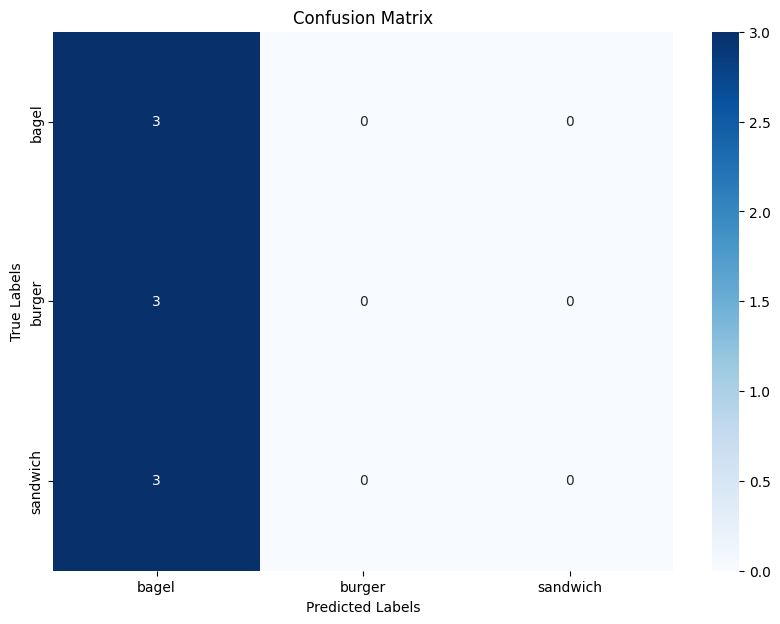

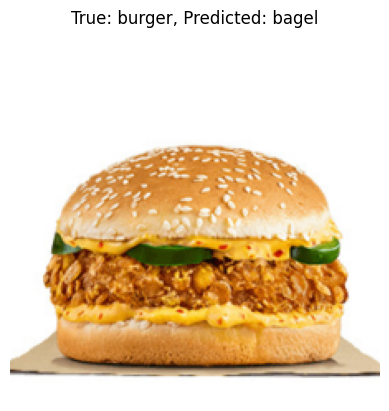

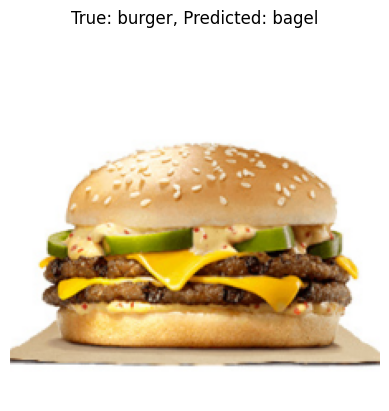

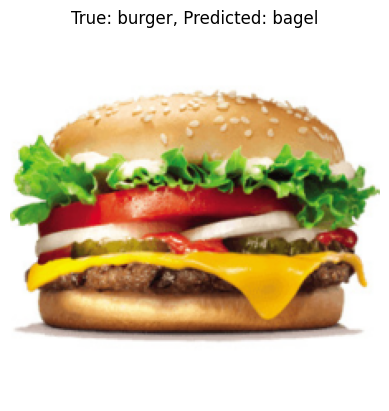

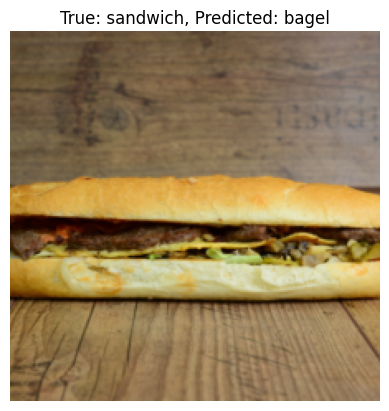

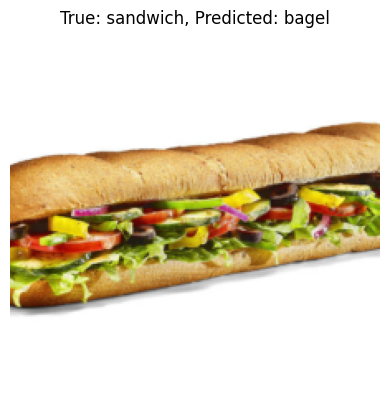

In [55]:
# An empty dictionary to store metrics
metrics_dict = {}

print("\nEvaluating Baseline Model:")
trainer.test(baseline_model, data_module)
baseline_metrics = evaluate_model(baseline_model, data_module.test_dataloader(), class_names)
metrics_dict["Baseline"] = baseline_metrics
visualize_errors(baseline_model, data_module.test_dataloader(), class_names, num_samples=5)

## Incremental model development

### Add complexity

In [25]:
class ComplexModel(pl.LightningModule):
    def __init__(self, num_classes=3, learning_rate=1e-3, weight_decay=1e-5, dropout_rate=0.5):
        super(ComplexModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.criterion = nn.CrossEntropyLoss()

        self.save_hyperparameters()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_epoch=True)
        self.log('val_acc', acc, on_epoch=True)
        return {'val_loss': loss, 'val_acc': acc}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return {'test_loss': loss, 'test_acc': acc}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return [optimizer], [scheduler]

In [26]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checks/',
    filename='best_complex_model',
    save_top_k=1,
    mode='min'
)

In [27]:
# Define the checkpoint path
best_complex_model_path = '/app/checks/best_complex_model.ckpt'

# Initialize the Trainer with the checkpoint callback
trainer = create_trainer(callbacks=[checkpoint_callback], max_epochs=default_max_epochs)

if TRAIN_MODELS_INSTEAD_OF_LOAD:
    complex_model = ComplexModel(
        num_classes=3,
        learning_rate=default_learning_rate,
        weight_decay=default_weight_decay
    )
    trainer.fit(complex_model, data_module)
else:
    if os.path.exists(best_complex_model_path):
        complex_model = ComplexModel.load_from_checkpoint(best_complex_model_path)
        complex_model.eval()
    else:
        complex_model = ComplexModel(
            num_classes=3,
            learning_rate=default_learning_rate,
            weight_decay=default_weight_decay
        )
        trainer.fit(complex_model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\kszon\Documents\GitHub\BMEVITMMA19_homework\checks exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | conv_layers | Sequential       | 19.4 K | train
1 | fc_layers   | Sequential       | 25.7 M | train
2 | criterion   | CrossEntropyLoss | 0      | train
---------------------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.840   Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.



Evaluating Complex Model:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3333333432674408     │
│         test_loss         │    1.0990910530090332     │
└───────────────────────────┴───────────────────────────┘

Accuracy: 0.3333
Precision: 0.1111
Recall: 0.3333
F1 Score: 0.1667

Classification Report:
              precision    recall  f1-score   support

       bagel       0.00      0.00      0.00         3
      burger       0.00      0.00      0.00         3
    sandwich       0.33      1.00      0.50         3

    accuracy                           0.33         9
   macro avg       0.11      0.33      0.17         9
weighted avg       0.11      0.33      0.17         9



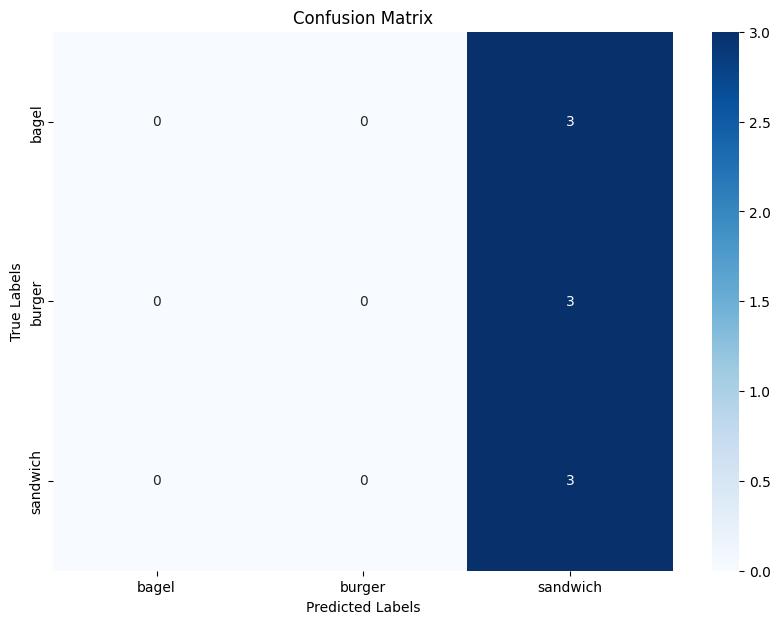

Selected Random Image: images/test\bagel\test_8.jpg


TypeError: Unexpected type <class 'str'>

In [57]:
# Test the ComplexModel
print("\nEvaluating Complex Model:")
trainer.test(complex_model, data_module)

# Evaluate model performance
complex_metrics = evaluate_model(complex_model, data_module.test_dataloader(), class_names)
metrics_dict["Complex"] = complex_metrics

# Visualize activations using a random image
folder_path = 'images/test'

try:
    visualize_all_activations_with_random_image(
        complex_model,
        folder_path,
        layers_to_visualize=[0, 3],
        model_type="complex"
    )
except ValueError as e:
    print(f"Error visualizing activations: {e}")

# Visualize error cases
visualize_errors(complex_model, data_module.test_dataloader(), class_names, num_samples=5)

visualize_feature_importance_with_random_image(complex_model, folder_path, model_type="complex", method="integrated_gradients")

### Use transfer learning

In [29]:
class TransferLearningModel(pl.LightningModule):
    def __init__(self, num_classes=3, learning_rate=1e-3, weight_decay=1e-5):
        super(TransferLearningModel, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.criterion = nn.CrossEntropyLoss()

        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().mean()
        self.log("test_loss", loss, prog_bar=True, on_epoch=True)
        self.log("test_acc", acc, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.learning_rate, 
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

        return [optimizer], [scheduler]

In [30]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checks/',
    filename='best_transfer_model',
    save_top_k=1,
    mode='min'
)

In [31]:
best_transfer_model_path = '/app/checks/best_transfer_model.ckpt'

trainer = create_trainer(callbacks=[checkpoint_callback], max_epochs=default_max_epochs)

if TRAIN_MODELS_INSTEAD_OF_LOAD:
    transfer_model = TransferLearningModel(
        num_classes=3,
        learning_rate=default_learning_rate,
        weight_decay=default_weight_decay
    )
    trainer.fit(transfer_model, data_module)
else:
    if os.path.exists(best_transfer_model_path):
        transfer_model = TransferLearningModel.load_from_checkpoint(best_transfer_model_path)
        transfer_model.eval()
    else:
        transfer_model = TransferLearningModel(
            num_classes=3,
            learning_rate=default_learning_rate,
            weight_decay=default_weight_decay
        )
        trainer.fit(transfer_model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\kszon\Documents\GitHub\BMEVITMMA19_home

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
# Test the TransferLearningModel
print("\nEvaluating Transfer Learning Model:")
trainer.test(transfer_model, data_module)

# Evaluate model performance
transfer_metrics = evaluate_model(transfer_model, data_module.test_dataloader(), class_names)
metrics_dict["Transfer"] = transfer_metrics

# Visualize activations using a random image
folder_path = 'images/test'

try:
    visualize_all_activations_with_random_image(
        transfer_model,
        folder_path,
        layers_to_visualize=['conv1', 'layer1'],
        model_type="transfer"
    )
except ValueError as e:
    print(f"Error visualizing activations: {e}")

# Visualize error cases
visualize_errors(transfer_model, data_module.test_dataloader(), class_names, num_samples=5)

visualize_feature_importance_with_random_image(transfer_model, folder_path, model_type="transfer", method="integrated_gradients")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

MisconfigurationException: You called `self.log(test_loss, ...)` twice in `test_step` with different arguments. This is not allowed

### Ensemble models

In [33]:
class EnsembleModel(pl.LightningModule):
    def __init__(self, models, learning_rate=1e-3, weight_decay=1e-5):
        super(EnsembleModel, self).__init__()
        self.models = models
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.criterion = nn.CrossEntropyLoss()

        # Save hyperparameters for reproducibility and logging
        self.save_hyperparameters(ignore=["models"])

        for model in self.models:
            if len(list(model.parameters())) == 0:
                print(f"Model {model.__class__.__name__} has no parameters.")

    def forward(self, x):
        # Forward pass through all models and take the average
        outputs = [model(x) for model in self.models]
        return torch.mean(torch.stack(outputs), dim=0)

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.criterion(outputs, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.criterion(outputs, y)
        acc = (torch.argmax(outputs, dim=1) == y).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        acc = (torch.argmax(outputs, dim=1) == y).float().mean()
        self.log('test_acc', acc)

    def configure_optimizers(self):
        params = [p for model in self.models for p in model.parameters()]
        
        if not params:
            raise ValueError("No parameters found for optimization.")

        optimizer = torch.optim.Adam(
            params, 
            lr=self.learning_rate, 
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

        return [optimizer], [scheduler]
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            outputs = self(x)
            predictions = torch.argmax(outputs, dim=1)
        return predictions

### Set up wandb and logging

In [34]:
wandb_logger = pl.loggers.WandbLogger(project='food-classification-homework', log_model="all")
early_stopping_callback = EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    mode="min"
)

In [35]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='checks/',
    filename='best_ensemble_model',
    save_top_k=1,
    mode='min'
)

In [36]:
best_ensemble_model_path = '/app/checks/best_ensemble_model.ckpt'

if DEPLOYMENT == False:
    trainer = create_trainer(
        logger=wandb_logger,
        callbacks=[early_stopping_callback, checkpoint_callback],
        max_epochs=default_max_epochs
    )
else:
    trainer = create_trainer(
        callbacks=[early_stopping_callback, checkpoint_callback],
        max_epochs=default_max_epochs
    )

if TRAIN_MODELS_INSTEAD_OF_LOAD:
    ensemble = EnsembleModel(models=[baseline_model, complex_model, transfer_model])
    trainer.fit(ensemble, data_module)
else:
    if os.path.exists(best_ensemble_model_path):
        print("It does exist!")
        ensemble = EnsembleModel.load_from_checkpoint(
            best_ensemble_model_path,
            models=[baseline_model, complex_model, transfer_model]
        )
        ensemble.eval()
    else:
        print("It does not exist!")
        ensemble = EnsembleModel(models=[baseline_model, complex_model, transfer_model])
        trainer.fit(ensemble, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\kszon\Documents\GitHub\BMEVITMMA19_homework\checks exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode


It does not exist!


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print("\nEvaluating Ensemble Model:")
trainer.test(ensemble, data_module)

if DEPLOYMENT == False:
    ensemble_metrics = evaluate_model(ensemble, data_module.test_dataloader(), class_names, logger=wandb_logger)
    metrics_dict["Ensemble"] = ensemble_metrics
    visualize_errors(ensemble, data_module.test_dataloader(), class_names, num_samples=5)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3333333432674408     │
└───────────────────────────┴───────────────────────────┘

### Sweep integration

In [38]:
# Baseline Sweep configuration
baseline_sweep_config = {
    "method": "random",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "model_type": {"values": ["baseline"]},
        "learning_rate": {"values": [1e-4, 1e-3, 1e-2]},
        "weight_decay": {"values": [1e-5, 1e-4, 1e-3]},
        "dropout_rate": {"values": [0.3, 0.5]},  # Relevant for baseline
        "batch_size": {"values": [32, 64]},
        "data_dir": {"values": ["images"]},
    },
}

In [39]:
# Complex Sweep configuration
complex_sweep_config = {
    "method": "random",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "model_type": {"values": ["complex"]},
        "learning_rate": {"values": [1e-4, 1e-3, 1e-2]},
        "weight_decay": {"values": [1e-5, 1e-4, 1e-3]},
        "dropout_rate": {"values": [0.3, 0.5]},  # Relevant for complex
        "batch_size": {"values": [32, 64]},
        "data_dir": {"values": ["images"]},
    },
}

In [40]:
# Transfer Sweep configuration
transfer_sweep_config = {
    "method": "random",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "model_type": {"values": ["transfer"]},
        "learning_rate": {"values": [1e-4, 1e-3, 1e-2]},
        "weight_decay": {"values": [1e-5, 1e-4, 1e-3]},
        "batch_size": {"values": [32, 64]},
        "data_dir": {"values": ["images"]},
    },
}

In [41]:
def training_function():
    wandb.init()
    config = wandb.config

    # Data module setup
    if not os.path.exists(config.data_dir):
        raise FileNotFoundError(f"Data directory {config.data_dir} not found.")

    data_module = BurgerBagelSandwichDataModule(
        data_dir=config.data_dir,
        batch_size=config.batch_size,
    )

    # Model selection based on config.model_type
    if config.model_type == "baseline":
        model = BaselineModel(
            num_classes=3,
            learning_rate=config.learning_rate,
            weight_decay=config.weight_decay,
            dropout_rate=config.dropout_rate,
        )
    elif config.model_type == "complex":
        model = ComplexModel(
            num_classes=3,
            learning_rate=config.learning_rate,
            weight_decay=config.weight_decay,
            dropout_rate=config.dropout_rate,
        )
    elif config.model_type == "transfer":
        model = TransferLearningModel(
            num_classes=3,
            learning_rate=config.learning_rate,
            weight_decay=config.weight_decay,
        )
    else:
        raise ValueError(f"Unknown model type: {config.model_type}")

    # Trainer with early stopping
    early_stopping_callback = pl.callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=5,
        verbose=True,
    )

    trainer = pl.Trainer(
        max_epochs=50,  # Fewer epochs for faster sweeps
        callbacks=[early_stopping_callback],
        logger=pl.loggers.WandbLogger(),
    )

    # Train the model
    trainer.fit(model, data_module)

    # Log the final validation loss
    wandb.log({"val_loss": trainer.callback_metrics.get("val_loss", None)})
    wandb.finish()

In [42]:
# Baseline Sweep
baseline_sweep_id = wandb.sweep(baseline_sweep_config, project="image-classification-sweep")
wandb.agent(baseline_sweep_id, function=training_function, count=3)

# Complex Sweep
complex_sweep_id = wandb.sweep(complex_sweep_config, project="image-classification-sweep")
wandb.agent(complex_sweep_id, function=training_function, count=3)

# Transfer Sweep
transfer_sweep_id = wandb.sweep(transfer_sweep_config, project="image-classification-sweep")
wandb.agent(transfer_sweep_id, function=training_function, count=3)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: m4ck4td1
Sweep URL: https://wandb.ai/k-szonja97-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem/image-classification-sweep/sweeps/m4ck4td1


wandb: Agent Starting Run: w5b7ii4s with config:
wandb: 	batch_size: 32
wandb: 	data_dir: images
wandb: 	dropout_rate: 0.3
wandb: 	learning_rate: 0.01
wandb: 	model_type: baseline
wandb: 	weight_decay: 0.001
wandb: Currently logged in as: k-szonja97 (k-szonja97-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\loggers\wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | conv_layer | Sequential       | 448    | train
1 | fc_layer   | Sequential       | 25.7 M | train
2 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.764   Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item '

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 79.710


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 64.798 >= min_delta = 0.0. New best score: 14.912


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 3.207 >= min_delta = 0.0. New best score: 11.706


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 6.939 >= min_delta = 0.0. New best score: 4.767


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 3.093 >= min_delta = 0.0. New best score: 1.674


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.407 >= min_delta = 0.0. New best score: 1.267


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.252


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.199


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.109 >= min_delta = 0.0. New best score: 1.090


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.090. Signaling Trainer to stop.


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
train_loss_epoch,█▄▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
val_acc,▃▃▄▄▁▅▃▃█▃▃▃▃▃
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,13
train_loss_epoch,1.09396
train_loss_step,1.10882
trainer/global_step,55
val_acc,0.33333


wandb: Agent Starting Run: ie47s360 with config:
wandb: 	batch_size: 32
wandb: 	data_dir: images
wandb: 	dropout_rate: 0.5
wandb: 	learning_rate: 0.001
wandb: 	model_type: baseline
wandb: 	weight_decay: 1e-05


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | conv_layer | Sequential       | 448    | train
1 | fc_layer   | Sequential       | 25.7 M | train
2 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.764   Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 4.358


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.781 >= min_delta = 0.0. New best score: 3.577


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.623 >= min_delta = 0.0. New best score: 2.953


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1.146 >= min_delta = 0.0. New best score: 1.807


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.759


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.596 >= min_delta = 0.0. New best score: 1.163


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.163. Signaling Trainer to stop.


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
train_loss_epoch,█▄▃▃▂▂▁▁▁▁▁▁▁▁
train_loss_step,▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
val_acc,▅▃▁▃█▃▅▃▃▅█▃▅▆
val_loss,▇█▆▅▂▆▂▂▁▂▂▂▁▁▁
epoch,13
train_loss_epoch,1.72453
train_loss_step,2.30858
trainer/global_step,55
val_acc,0.37778


wandb: Agent Starting Run: c1qncu0x with config:
wandb: 	batch_size: 32
wandb: 	data_dir: images
wandb: 	dropout_rate: 0.5
wandb: 	learning_rate: 0.01
wandb: 	model_type: baseline
wandb: 	weight_decay: 0.0001


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | conv_layer | Sequential       | 448    | train
1 | fc_layer   | Sequential       | 25.7 M | train
2 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.764   Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 116.846


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 82.890 >= min_delta = 0.0. New best score: 33.956


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 25.717 >= min_delta = 0.0. New best score: 8.239


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 3.056 >= min_delta = 0.0. New best score: 5.183


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.162 >= min_delta = 0.0. New best score: 5.021


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 3.855 >= min_delta = 0.0. New best score: 1.166


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇███
train_loss_epoch,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▁█▆▂
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
val_acc,▅▅▅▁█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
train_loss_epoch,1.09849
train_loss_step,1.09919
trainer/global_step,199
val_acc,0.33333


Create sweep with ID: 8y1mh8rb
Sweep URL: https://wandb.ai/k-szonja97-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem/image-classification-sweep/sweeps/8y1mh8rb


wandb: Agent Starting Run: sq0vcfs4 with config:
wandb: 	batch_size: 32
wandb: 	data_dir: images
wandb: 	dropout_rate: 0.5
wandb: 	learning_rate: 0.001
wandb: 	model_type: complex
wandb: 	weight_decay: 1e-05


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | conv_layers | Sequential       | 19.4 K | train
1 | fc_layers   | Sequential       | 25.7 M | train
2 | criterion   | CrossEntropyLoss | 0      | train
---------------------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.840   Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 1.820


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.722 >= min_delta = 0.0. New best score: 1.098


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.098. Signaling Trainer to stop.


epoch,▁▁▂▂▃▃▅▅▆▆▇▇██
train_loss_epoch,█▄▁▁▁▁▁
trainer/global_step,▁▁▂▂▃▃▅▅▆▆▇▇██
val_acc,▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁
epoch,6
train_loss_epoch,1.10008
trainer/global_step,27
val_acc,0.33333
val_loss,1.09923


wandb: Agent Starting Run: h203xyqy with config:
wandb: 	batch_size: 32
wandb: 	data_dir: images
wandb: 	dropout_rate: 0.3
wandb: 	learning_rate: 0.001
wandb: 	model_type: complex
wandb: 	weight_decay: 0.0001


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | conv_layers | Sequential       | 19.4 K | train
1 | fc_layers   | Sequential       | 25.7 M | train
2 | criterion   | CrossEntropyLoss | 0      | train
---------------------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.840   Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 1.265


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.149 >= min_delta = 0.0. New best score: 1.115


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.103


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.100


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.100


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.100


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.100


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.100


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.100


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.100


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.100


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.100


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.100


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.100


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.099


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.099. Signaling Trainer to stop.


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss_epoch,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▁
trainer/global_step,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
val_acc,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,25
train_loss_epoch,1.09911
train_loss_step,1.09695
trainer/global_step,103
val_acc,0.33333


wandb: Agent Starting Run: tsecihqr with config:
wandb: 	batch_size: 32
wandb: 	data_dir: images
wandb: 	dropout_rate: 0.5
wandb: 	learning_rate: 0.0001
wandb: 	model_type: complex
wandb: 	weight_decay: 1e-05


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | conv_layers | Sequential       | 19.4 K | train
1 | fc_layers   | Sequential       | 25.7 M | train
2 | criterion   | CrossEntropyLoss | 0      | train
---------------------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.840   Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 1.110


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.105


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.105. Signaling Trainer to stop.


epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
train_loss_epoch,▇█▅▃▃▃▁▂▂▁▁
trainer/global_step,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
val_acc,▁▆▆▆▆▆▆█▆▆▆
val_loss,▂▃▅▇▂▁▄▄▄█▆▆
epoch,10
train_loss_epoch,1.02516
trainer/global_step,43
val_acc,0.33333
val_loss,1.13959


Create sweep with ID: 1dhno030
Sweep URL: https://wandb.ai/k-szonja97-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem/image-classification-sweep/sweeps/1dhno030


wandb: Agent Starting Run: 0m58hbfn with config:
wandb: 	batch_size: 32
wandb: 	data_dir: images
wandb: 	learning_rate: 0.0001
wandb: 	model_type: transfer
wandb: 	weight_decay: 1e-05


c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kszon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 11.2 M | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 1.079


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.240 >= min_delta = 0.0. New best score: 0.839


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.126 >= min_delta = 0.0. New best score: 0.714


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.692


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.692. Signaling Trainer to stop.


epoch,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
train_loss_epoch,█▆▄▃▂▃▂▁▂
trainer/global_step,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
val_acc,▁▆██▆▆▅▃▃
val_loss,▇▃▁▁▁▂▄▇██
epoch,8
train_loss_epoch,0.3287
trainer/global_step,35
val_acc,0.48889
val_loss,1.16448


wandb: Agent Starting Run: snc4v1a6 with config:
wandb: 	batch_size: 32
wandb: 	data_dir: images
wandb: 	learning_rate: 0.0001
wandb: 	model_type: transfer
wandb: 	weight_decay: 0.0001


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 11.2 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.974


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 0.852


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.789


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.732


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 0.674


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.632


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.607


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.605


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.577


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.577. Signaling Trainer to stop.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁▂▁▁
train_loss_step,▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
val_acc,▁▄▄▅▅▅▅▆▆▇▇█▇▇▆▆▆▆
val_loss,█▆▅▄▃▄▄▃▂▂▁▂▁▁▂▂▂▂▂
epoch,17
train_loss_epoch,0.19618
train_loss_step,0.25405
trainer/global_step,71
val_acc,0.71111


wandb: Agent Starting Run: n90lx255 with config:
wandb: 	batch_size: 32
wandb: 	data_dir: images
wandb: 	learning_rate: 0.01
wandb: 	model_type: transfer
wandb: 	weight_decay: 0.001


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 11.2 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 191182160.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 189675952.000 >= min_delta = 0.0. New best score: 1506202.625


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1502807.750 >= min_delta = 0.0. New best score: 3394.910


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 3386.110 >= min_delta = 0.0. New best score: 8.800


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 7.670 >= min_delta = 0.0. New best score: 1.130


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.112


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.112. Signaling Trainer to stop.


epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
train_loss_epoch,█▆▂▂▁▂▁▂▁▁▁
trainer/global_step,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
val_acc,▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁
epoch,10
train_loss_epoch,1.14645
trainer/global_step,43
val_acc,0.33333
val_loss,1.13422


### Model Comparison

In [ ]:
def compare_models(metrics_dict):
    print("\nModel Performance Comparison:")
    # Header
    print(f"{'Model':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
    print("-" * 55)
    # Iterate over the metrics dictionary
    for model_name, metrics in metrics_dict.items():
        print(f"{model_name:<15} "
              f"{metrics['accuracy']:<10.4f} "
              f"{metrics['precision']:<10.4f} "
              f"{metrics['recall']:<10.4f} "
              f"{metrics['f1_score']:<10.4f}")

In [ ]:
compare_models(metrics_dict)

### Visualize the Comparison

In [ ]:
# Prepare data
labels = list(metrics_dict.keys())
accuracy = [metrics["accuracy"] for metrics in metrics_dict.values()]
precision = [metrics["precision"] for metrics in metrics_dict.values()]
recall = [metrics["recall"] for metrics in metrics_dict.values()]
f1_score = [metrics["f1_score"] for metrics in metrics_dict.values()]

x = np.arange(len(labels))
width = 0.2

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
rects1 = ax.bar(x - 1.5 * width, accuracy, width, label="Accuracy")
rects2 = ax.bar(x - 0.5 * width, precision, width, label="Precision")
rects3 = ax.bar(x + 0.5 * width, recall, width, label="Recall")
rects4 = ax.bar(x + 1.5 * width, f1_score, width, label="F1 Score")

# Add text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel("Models")
ax.set_ylabel("Scores")
ax.set_title("Comparison of Model Performance")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Attach a text label above each bar in rects, displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text vertically by 3 points
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.show()

### Load up the best model from the run

In [43]:
""" best_model_path = checkpoint_callback.best_model_path
best_model = EnsembleModel.load_from_checkpoint(best_model_path, models=[baseline_model, complex_model, transfer_model])

evaluate_model(best_model, data_module.test_dataloader(), class_names, logger=wandb_logger) """
best_model = ensemble

In [44]:
## Run this if you interrupted the run

if DEPLOYMENT == False:
    wandb.finish()

### Make a prediction on a test bagel image

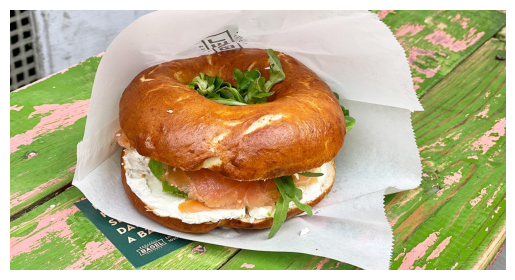

The predicted class for the image is: sandwich


In [45]:
image_path = './images/test/bagel/test_1.jpg'
predict_image(best_model, image_path)


### Make a prediction on a test burger image

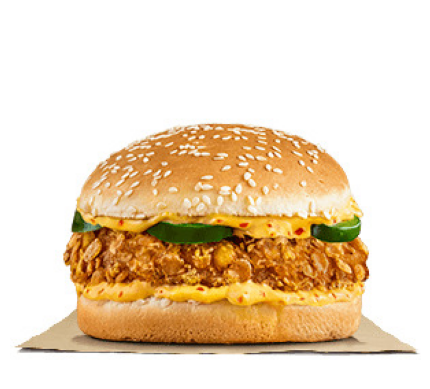

The predicted class for the image is: burger


In [46]:
image_path_2 = './images/test/burger/test_5.jpg'
predict_image(best_model, image_path_2)

### Make a prediction on a test sandwich image

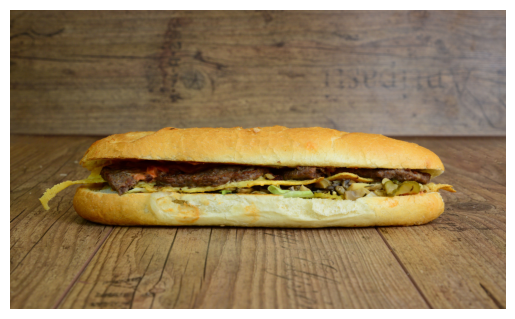

The predicted class for the image is: sandwich


In [47]:
image_path_2 = './images/test/sandwich/test_3.jpg'
predict_image(best_model, image_path_2)

# Milestone 3

## Create the UI and service

Add preprocesser function for prediction

In [48]:
def preprocess_image(image, resolution=224):
    preprocess = transforms.Compose([
        transforms.Resize(resolution),
        transforms.CenterCrop(resolution),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img_tensor = preprocess(image)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    return img_tensor

Add predict function that returns the predicted label of the input image with the input model

In [49]:
def predict_image(model, image_path):
    model.to(device)
    model.eval()

    if isinstance(image_path, str):
        img = Image.open(image_path)
    else:
        img = Image.fromarray(image_path)

    img_tensor = preprocess_image(img)

    with torch.no_grad():
        output = model(img_tensor.to(device))

    predicted_class_index = torch.argmax(output, dim=1).item()

    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

Define cleanup, so when the container stops, the server closes

In [50]:
import signal
import logging

def cleanup():
    logging.info("Shutting down the server")
    gr.close_all()

signal.signal(signal.SIGTERM, cleanup)

<Handlers.SIG_DFL: 0>

Make the gradio UI and server

In [51]:
history = []

def predict(image):
    label = predict_image(transfer_model, image)
    
    history.append((image, label))
    
    return history

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="filepath", label="Input Image"),
    outputs=gr.Gallery(label="Processed Images"),
)

logging.info("Starting the server at http://localhost:7860")
server = demo.launch(server_port=7860, debug=True)

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


In [ ]:
## Run this if you want to close the running servers
gr.close_all()